In [1]:
#Import data mainpulation modules
import pandas as pd
import numpy as np

#Import graphing libraries
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()

#Import prophet function fb prophet
from fbprophet import Prophet

#Import time to track time of process
import time

#Import tqdm to check process of parallelization
from tqdm import tqdm

In [2]:
#Read data in
dat = pd.read_csv('../Data/bike_sharing_hourly.csv', parse_dates=['dteday'])

In [3]:
# Convert to datetime format
dat['dteday'] = pd.to_datetime(dat.dteday) + dat.hr.astype('timedelta64[h]')

In [4]:
#Make dteday dataframe's index
dat.set_index('dteday', drop=True, inplace=True)

In [5]:
#Create new column with a log of counts
dat['log_cnt'] = np.log(dat.cnt) + 1 #add constant to change 0's to 1's

In [6]:
#Convert weathersit into multiple dummy variables
wsit_dummies = pd.get_dummies(dat.weathersit)
wsit_dummies = wsit_dummies.iloc[:,0:3] #Drop one to avoid dummy variables trap

#Join dummies to original df
dat = dat.join(wsit_dummies)

In [7]:
#Check columns of data
dat.tail(2)

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,log_cnt,1,2,3
dteday,,,,,,,,,,,,,,,,,,,,
2012-12-31 22:00:00,17378,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61,5.110874,1,0,0
2012-12-31 23:00:00,17379,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49,4.891820,1,0,0


In [8]:
#Create dataframe of holidays
hol_df = pd.DataFrame({'holiday': 'hol', 'ds': dat[dat['holiday'] == 1].index})

# Predicting with FB Prophet

In [9]:
#Function to create train and test splits
def train_test_splits(dat, val_dates):
    
    '''
    Function that splits training data into training and validation 
    sets using an expanding window. 
    Inputs:       dat - Training data to be split
            val_dates - List of dates to create validation sets. Must include last month 
                        of training data
    Outputs: expanding_window_indices - List with tuples of train and validation set indices
    '''
    
    #Initialize counter
    pos = 0
    expanding_window_indices = []

    #Iterate over all values except the last in list of dates
    for date in val_dates[:-1]:
    
        #Create training set
        train = dat[ : date]
        val_len = len(val_dates) - 1 #Count starts from 0
    
        #Create variable to move to the next date
        next_date = pos+1 if (pos+1 < val_len) else val_len
    
        #Creat validation split
        val = dat[ : val_dates[next_date]]
    
        pos += 1#Update counter
    
        #Create train and test set indices
        expanding_window_indices.append([train.index, val.index])
        
    return expanding_window_indices   

In [10]:
#Functions to compute error metrics
def accuracy(pred, obs):
    
    '''
    Computes mean absolute percentage error
    Inputs: pred - Array of predicted/forecasted values
             obs - Array of actual values to be forecast
    Outputs: error_metrics - Dictionary with 3 values; RMSE, MAE, MAPE
    '''
    
    error_metrics = {}
    
    #Convert inputs to numpy arrays
    pred, obs = np.array(pred), np.array(obs)
    
    #Compute error metrics
    error_metrics['MAPE'] = np.mean(np.abs((obs - pred)/obs))*100
    error_metrics['RMSE'] = np.sqrt(np.mean((obs - pred)**2))
    error_metrics['MAE'] = np.mean(np.abs((obs - pred)))
    
    return error_metrics

In [11]:
#Function to reverse transformation
def back_transform(og_pred_counts, pred_log_cnt, c=1):
    
    '''
    Reverse log transformation using bias adjustment to get mean of forecast distributions
    Inputs: pred_log_cnt - Pandas series of predicted log counts
                       c - Integer representing constant added to log values to avoid 0
    Outputs:          w0 - Pandas series of bias adjusted back transformed counts        
    '''
    
    w0 = np.exp(pred_log_cnt - c)
    
    #Compute constant using MM correction factor
    D = np.mean(og_pred_counts) / np.mean(w0)
    w = w0*D
    
    return w

## Step 1: Creating a grid of parameter values

In [12]:
#Create grid of hyper parameters to tune
from sklearn.model_selection import ParameterGrid

#Dictionary of hyper parameters to tune
hyper_params = {'d_fr' : [55, 65], 
                'w_fr' : [20,30], 
                'y_fr' : [20,30], 
                'seas_prior' : [35,60]}

#Build grid
grid = list(ParameterGrid(hyper_params))

In [13]:
def fit_fb_prophet(full_dat, train_dat, seas_params):
    
    '''
    Fits FB prophet with user specified arguements
    Inputs:    full_dat - Pandas dataframe which includes future test values to test on
              train_dat - Pandas dataframe to train model on; contains column og log counts
            seas_params - Dictionary with 4 key-value pairs to train model with
    Outputs:    errorrs - Dictionary of test snd training set errors     
    '''
    
    #Create a dataframe to run prophet on
    fb_df = pd.DataFrame()

    fb_df['ds'] = train_dat.index#dat.index
    fb_df['y'] = train_dat.log_cnt.values#np.log(dat.cnt.values)

    #Add columns of regressors to be used
    fb_df['temp'] = train_dat.atemp.values
    fb_df['hum'] = train_dat.hum.values
    fb_df['ws'] = train_dat.windspeed.values

    #Add columns for each level of weather sit
    fb_df['w1'] = train_dat.loc[:,1].values
    fb_df['w2'] = train_dat.loc[:,2].values
    fb_df['w3'] = train_dat.loc[:,3].values
    
    #Initialize model
    base_mod = Prophet(growth='linear', n_changepoints=(12*2*1), 
                       seasonality_mode='additive', 
                       seasonality_prior_scale=seas_params['seas_prior'], 
                       daily_seasonality=False, 
                       weekly_seasonality=False, yearly_seasonality=False)
    
    #Add seasonalities by varying fourier terms
    base_mod.add_seasonality(name='Daily', period = 1, fourier_order=seas_params['d_fr'])
    base_mod.add_seasonality(name='Weekly', period = 7, fourier_order=seas_params['w_fr'])
    base_mod.add_seasonality(name='Yearly', period = (365.25), 
                             fourier_order=seas_params['y_fr'])

    #Add holidays using built in function
    base_mod.add_country_holidays(country_name='US')

    #Add regressors and fit model
    base_mod.add_regressor('temp', standardize=False)
    base_mod.add_regressor('hum', standardize=False)
    base_mod.add_regressor('ws', standardize=False)
    base_mod.add_regressor('w1', standardize=False)
    base_mod.add_regressor('w2', standardize=False)
    base_mod.add_regressor('w3', standardize=False)
    base_mod.fit(fb_df) #fit model
    
    #Make predictions
    n_preds = len(full_dat) - len(train_dat)
    future_vals = base_mod.make_future_dataframe(freq='H', periods=n_preds)

    #Add columns with future values of additional regressor variables
    future_vals['temp'] = full_dat.atemp.values
    future_vals['hum'] = full_dat.hum.values
    future_vals['ws'] = full_dat.windspeed.values
    future_vals['w1'] = full_dat.loc[:,1].values
    future_vals['w2'] = full_dat.loc[:,2].values
    future_vals['w3'] = full_dat.loc[:,3].values
    
    #Predict values
    base_pred = base_mod.predict(future_vals)
    
    #Compute log count error
    base_train_error = accuracy(pred=base_pred.yhat[:full_dat.shape[0] - n_preds], 
                                    obs=full_dat.log_cnt[:full_dat.shape[0] - n_preds])
    base_val_error = accuracy(pred=base_pred.yhat.tail(n_preds), 
                                   obs=full_dat.log_cnt.tail(n_preds))
    
    #Compute count errors on original scale
    pred_og_scale = back_transform(og_pred_counts=full_dat.cnt.tail(n_preds), 
                                   pred_log_cnt=base_pred.yhat.tail(n_preds))
    og_val_cnt = full_dat.cnt.tail(n_preds)
    
    base_error = accuracy(pred_og_scale, og_val_cnt)
    
    #Store errors
    errors = {'log_val_error':base_val_error, 'val_error':base_error}
    
    return errors

In [14]:
#Dates to create validation sets on
v_dates = ['Aug 2012', 'Sep 2012', 'Oct 2012', 'Nov 2012']

In [15]:
def expand_wind_val(p_comb, dat=dat, val_dte=v_dates):
    
    '''
    Get a better estimate of MAE using expanding window validation. 
    Inputs:         dat - Pandas dataframe to split into train and train+val sets
                 p_comb - Dictionary of param combinations to try
                val_dte - List of dates to split data into training and test sets
    Ouptuts     avg_mae - List of MAE scores averaged across all validation splits
    '''
    
    #Create split indices
    split_indices = train_test_splits(dat, val_dte)
    
    #Initialization
    n_reps = len(split_indices)
    avg_mae = []
    avg_log_mae = []
    
    for j in range(n_reps):
        #Split data into train and train+validation sets
        train = dat[dat.index.isin(split_indices[j][0])]
        full = dat[dat.index.isin(split_indices[j][1])]
            
        #Empty list to store values in
        mae = []
        log_mae = []  
        
        #Compute accuracy scores
        acc = fit_fb_prophet(full_dat=full, train_dat=train, seas_params=p_comb)
        mae.append(acc['val_error']['MAE'])
        log_mae.append(acc['log_val_error'])
        #print(mae)
    avg_mae.append(np.mean(mae))
    avg_log_mae.append(log_mae)  
    
    return avg_mae, avg_log_mae

In [16]:
#Check if multi processing will speed things up
print(grid)

from multiprocessing import Pool, cpu_count
start_time = time.time()
p = Pool(cpu_count())
mae_scores = list(p.imap(expand_wind_val, grid))
p.close()
p.join()
print("--- %s seconds ---" % (time.time() - start_time))

[{'d_fr': 55, 'seas_prior': 35, 'w_fr': 20, 'y_fr': 20}, {'d_fr': 55, 'seas_prior': 35, 'w_fr': 20, 'y_fr': 30}, {'d_fr': 55, 'seas_prior': 35, 'w_fr': 30, 'y_fr': 20}, {'d_fr': 55, 'seas_prior': 35, 'w_fr': 30, 'y_fr': 30}, {'d_fr': 55, 'seas_prior': 60, 'w_fr': 20, 'y_fr': 20}, {'d_fr': 55, 'seas_prior': 60, 'w_fr': 20, 'y_fr': 30}, {'d_fr': 55, 'seas_prior': 60, 'w_fr': 30, 'y_fr': 20}, {'d_fr': 55, 'seas_prior': 60, 'w_fr': 30, 'y_fr': 30}, {'d_fr': 65, 'seas_prior': 35, 'w_fr': 20, 'y_fr': 20}, {'d_fr': 65, 'seas_prior': 35, 'w_fr': 20, 'y_fr': 30}, {'d_fr': 65, 'seas_prior': 35, 'w_fr': 30, 'y_fr': 20}, {'d_fr': 65, 'seas_prior': 35, 'w_fr': 30, 'y_fr': 30}, {'d_fr': 65, 'seas_prior': 60, 'w_fr': 20, 'y_fr': 20}, {'d_fr': 65, 'seas_prior': 60, 'w_fr': 20, 'y_fr': 30}, {'d_fr': 65, 'seas_prior': 60, 'w_fr': 30, 'y_fr': 20}, {'d_fr': 65, 'seas_prior': 60, 'w_fr': 30, 'y_fr': 30}]


/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:39

/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  

/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  

--- 4745.036541938782 seconds ---


In [19]:
#Get index of lowest MAE validation score
print(mae_scores)
print('lowest log validation MAE is')
raw_mae_scores = [i[0] for i in mae_scores]
raw_mae_scores
min_mae_index = raw_mae_scores.index(min(raw_mae_scores))
opt_comb = grid[min_mae_index]
opt_comb

[([86.57330482442228], [[{'MAPE': 12.838046788714191, 'RMSE': 0.7655964376923254, 'MAE': 0.5668559269434208}]]), ([85.52375182392542], [[{'MAPE': 12.670284644817281, 'RMSE': 0.7543772491890575, 'MAE': 0.5606928263876052}]]), ([79.96661666380285], [[{'MAPE': 12.796299134455758, 'RMSE': 0.7646981043940452, 'MAE': 0.555378181000402}]]), ([78.63081314547219], [[{'MAPE': 12.618149475857768, 'RMSE': 0.7537351861944336, 'MAE': 0.5481330029175694}]]), ([86.54517676953866], [[{'MAPE': 12.819104491053492, 'RMSE': 0.7651754423712026, 'MAE': 0.5662975592492554}]]), ([85.51341405369192], [[{'MAPE': 12.659741312832265, 'RMSE': 0.7541618041874784, 'MAE': 0.5604116531031401}]]), ([79.98706426652551], [[{'MAPE': 12.807099524924343, 'RMSE': 0.7649108708516387, 'MAE': 0.5557180487906217}]]), ([78.65653251760926], [[{'MAPE': 12.635609348477015, 'RMSE': 0.7540408097670792, 'MAE': 0.548664750512341}]]), ([86.54575592472271], [[{'MAPE': 12.819284520724256, 'RMSE': 0.765183436133742, 'MAE': 0.5663079677621756

{'d_fr': 65, 'seas_prior': 35, 'w_fr': 30, 'y_fr': 30}

## Step 3: Testing Tuned Model

In [20]:
#Create train and test splits
train = dat['Jan 2011': 'November 2012']
test = dat['December 2012']

## Visualizing Train and Test Splits

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


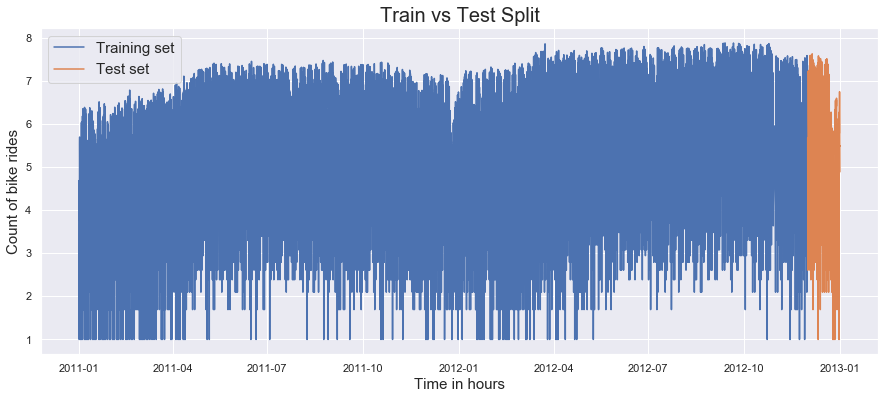

In [21]:
#Create plot
plt.figure(figsize=(15,6))
plt.xlabel('Time in hours', size=15)
plt.ylabel('Count of bike rides', size=15)
plt.title('Train vs Test Split', size=20)
plt.plot(train.index,train.loc[:,'log_cnt'], label='Training set')
plt.plot(test.index,test.loc[:,'log_cnt'], label='Test set')
plt.legend(prop={'size': 15})

#Save plot 
#plt.savefig('Train_test_split.pdf')

In [22]:
#Create a dataframe to run prophet on
fb_df = pd.DataFrame()

fb_df['ds'] = train.index#dat.index
fb_df['y'] = train.log_cnt.values#np.log(dat.cnt.values)

#Add columns of regressors to be used
fb_df['temp'] = train.atemp.values
fb_df['hum'] = train.hum.values
fb_df['ws'] = train.windspeed.values

#Add columns for each level of weather sit
fb_df['w1'] = train.loc[:,1].values
fb_df['w2'] = train.loc[:,2].values
fb_df['w3'] = train.loc[:,3].values

In [23]:
#Number of future predictions to make
n_preds = test.shape[0]
n_preds

742

## Tuned Model + Additional Regressors

In [24]:
#Initialize model
base_mod = Prophet(growth='linear',
                   n_changepoints=(12*2*1), 
                   seasonality_mode='additive', 
                   seasonality_prior_scale=opt_comb['seas_prior'], 
                   daily_seasonality=False, 
                   weekly_seasonality=False,
                   yearly_seasonality=False)

In [25]:
#Add seasonalities by varying fourier terms
#base_mod.add_seasonality(name='Monthly', period = (365.25/12), fourier_order=55)
base_mod.add_seasonality(name='Daily', period = 1, fourier_order=opt_comb['d_fr'])
base_mod.add_seasonality(name='Weekly', period = 7, fourier_order=opt_comb['w_fr'])
#base_mod.add_seasonality(name='Quarterly', period = (365.25/4), fourier_order=5)
base_mod.add_seasonality(name='Yearly', period = (365.25), fourier_order=opt_comb['y_fr'])

#Add holidays using built in function
base_mod.add_country_holidays(country_name='US')

#Add regressors and fit model
base_mod.add_regressor('temp', standardize=False)
base_mod.add_regressor('hum', standardize=False)
base_mod.add_regressor('ws', standardize=False)
base_mod.add_regressor('w1', standardize=False)
base_mod.add_regressor('w2', standardize=False)
base_mod.add_regressor('w3', standardize=False)
base_mod.fit(fb_df)

/anaconda3/lib/python3.7/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [26]:
#Make predictions
future_vals = base_mod.make_future_dataframe(freq='H', periods=n_preds)

#Add columns with future values of additional regressor variables
future_vals['temp'] = dat.atemp.values
future_vals['hum'] = dat.hum.values
future_vals['ws'] = dat.windspeed.values
future_vals['w1'] = dat.loc[:,1].values
future_vals['w2'] = dat.loc[:,2].values
future_vals['w3'] = dat.loc[:,3].values

In [27]:
#Predict values
base_pred = base_mod.predict(future_vals)

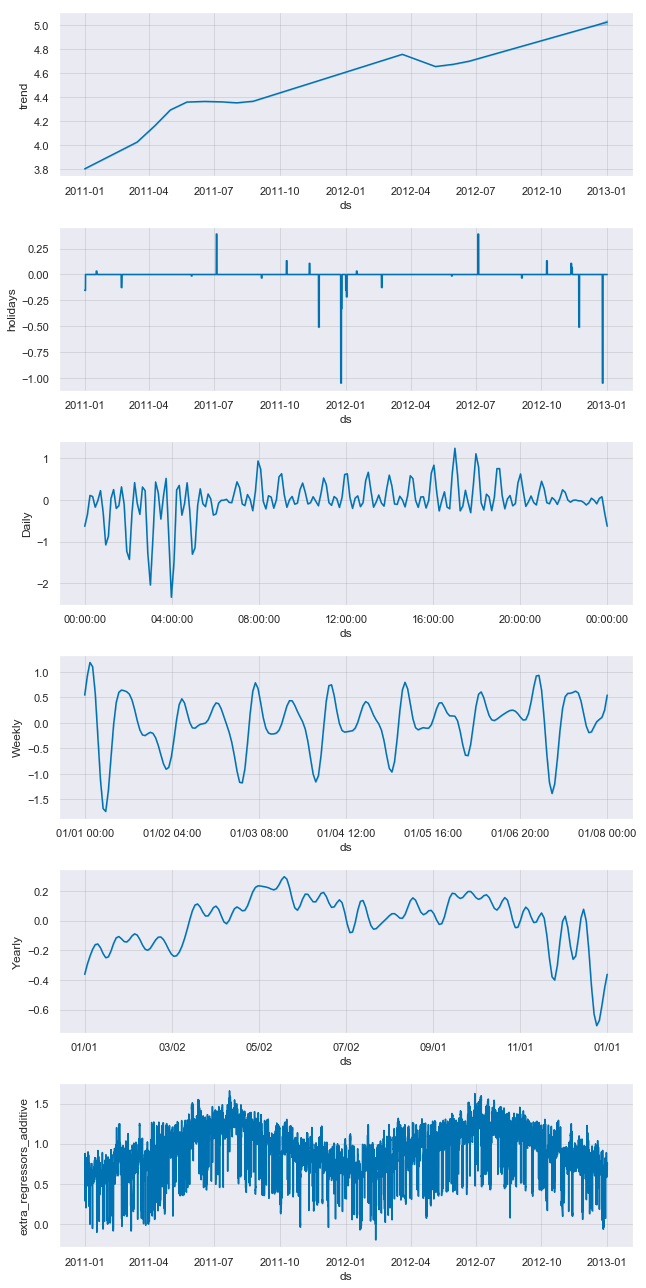

In [28]:
fig2=base_mod.plot_components(base_pred)
#plt.savefig('effects_fbprop.pdf')

In [29]:
#Plot predicted vs forecast values
# plt.figure(figsize=(14,6))
# plt.plot(dat.index, dat.loc[:,'log_cnt'], label='Observed')
# plt.plot(dat.index, base_pred.loc[:,'yhat'], label='Predicted')
# plt.ylabel('Log Counts', size=15)
# plt.xlabel('Time', size=15)
# plt.title('Bike Ride count Predictions using Facebook\'s GAM', size = 20)
# plt.legend()
# plt.savefig('addreg_fbprop.pdf')

In [30]:
#Compute log count error
base_train_set_error = accuracy(pred=base_pred.yhat[:dat.shape[0] - n_preds], 
                                obs=dat.log_cnt[:dat.shape[0] - n_preds])
print(base_train_set_error)

base_test_set_error = accuracy(pred=base_pred.yhat.tail(n_preds), 
                               obs=dat.log_cnt.tail(n_preds))
base_test_set_error

{'MAPE': 6.565889157084093, 'RMSE': 0.37582641062463895, 'MAE': 0.25597005634582903}


{'MAPE': 11.684441121018558,
 'RMSE': 0.666832036042809,
 'MAE': 0.4446482318223007}

## Back transforming predictions

In [35]:
#Compute train set error
train_pred_og_scale = back_transform(og_pred_counts=dat.cnt[:dat.shape[0] - n_preds],
                                     pred_log_cnt=base_pred.yhat[:dat.shape[0] - n_preds])
og_train_cnt = dat.cnt[:dat.shape[0] - n_preds]

In [36]:
accuracy(train_pred_og_scale, og_train_cnt)

{'MAPE': 30.2937555764668, 'RMSE': 58.28190018448983, 'MAE': 34.26974172081049}

In [39]:
#Compute test set accuracy
pred_og_scale = back_transform(og_pred_counts=dat.cnt.tail(n_preds), 
                               pred_log_cnt=base_pred.yhat.tail(n_preds))
og_test_cnt = dat.cnt.tail(n_preds)

In [40]:
accuracy(pred_og_scale, og_test_cnt)

{'MAPE': 69.06349862507696,
 'RMSE': 65.02848638451479,
 'MAE': 44.23299200690746}

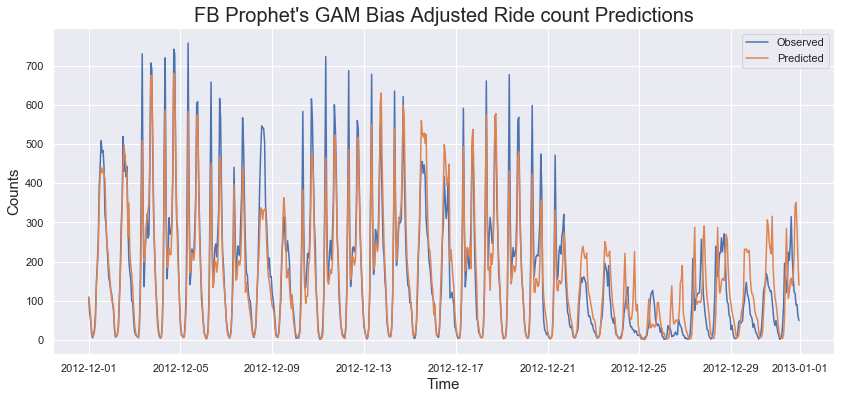

In [41]:
#Plot transformed predicted vs forecast values
plt.figure(figsize=(14,6))
plt.plot(og_test_cnt.index, og_test_cnt.values, label='Observed')
plt.plot(og_test_cnt.index, pred_og_scale, label='Predicted')
plt.ylabel('Counts', size=15)
plt.xlabel('Time', size=15)
plt.title('FB Prophet\'s GAM Bias Adjusted Ride count Predictions', size = 20)
plt.legend()
#plt.savefig('no_addreg_fbprop.pdf')

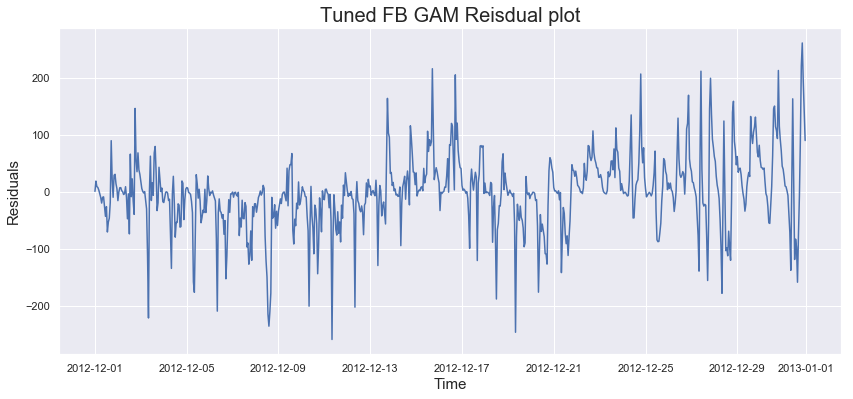

In [47]:
#Residual analysis
residuals = (pred_og_scale - og_test_cnt.values)
plt.figure(figsize=(14,6))
plt.plot(og_test_cnt.index, residuals)
plt.xlabel('Time', size=15)
plt.ylabel('Residuals', size=15)
plt.title('Tuned FB GAM Reisdual plot', size = 20)
#plt.savefig('../Pictures/Model_comparisons/tuned_fb_residual_plot.pdf')